<h1 align="center"><b>Programming Assignment 2 (100 points total)</b></h1>
<h3 align="center"><b>Due at the end of Module 14</b></h3><br>


In [1]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import numpy as np 
from numpy.linalg import eigh
import pandas as pd 
from scipy.fft import dct 
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Question 1: MNIST Feature Extraction and Classification (50 Points Total)

### **Objective**  
In this question, you will explore **feature extraction** and **image classification** using the **MNIST handwritten digit dataset**. Your task is to preprocess raw image data, apply the **2D Discrete Cosine Transform (DCT)**, extract directionally informative coefficients using **frequency masks**, and conduct **dimensionality reduction via eigen decomposition**. You will then use the resulting features to train and compare multiple **classification algorithms**, including traditional machine learning and deep learning approaches.

- **Dataset:** [MNIST Handwritten Digit Dataset](https://www.openml.org/d/554)  
- **Focus Areas:** **Signal-based feature engineering**, **dimensionality reduction**, **supervised classification**, and **model comparison**.

---

### **Part 1: Preprocessing and Visualization (10 Points)**
#### **Instructions:**
1. Load the **MNIST Dataset** and inspect its structure (e.g., flattened vector, first column label, no. of observations).
   You can use the following code below:
```python
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
```
2. Display example images of each written number 0-9. 
3. Final dataset must include representative samples from each digit class (at least 100 per class). We understand compute limitations and thus do not require all observations but you can use all if you so choose.

#### **Deliverables:**
- 9 black & white images of an example of a handwritten digit from the dataset
- Output showing how many observations and features 
- Proof that you have a representative sample from each class


In [2]:
# 1. Load MNIST Dataset and inspect structure 
#       The given code for loading the data does not work, so using tensorflow instead of sklearn to load in the mnist data 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Training Data Shape: {x_train.shape}")
print(f"Training Label Shape: {y_train.shape}")
print(f"\nTesting Data Shape: {x_test.shape}")
print(f"Testing Label Shape: {y_test.shape}")

Training Data Shape: (60000, 28, 28)
Training Label Shape: (60000,)

Testing Data Shape: (10000, 28, 28)
Testing Label Shape: (10000,)


Above, we can see that there are 60,000 training examples and 10,000 testing examples in the MNIST dataset. Each data point/example is a 2D array of shape 28x28 pixels. These 28x28 pixel arrays will be the input to the model, meaning that these are our "features". We can think of this as 784 input features (28 * 28 = 784). 

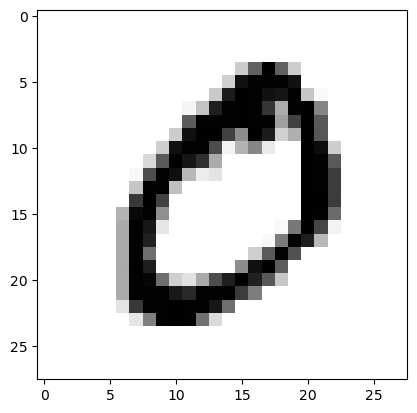

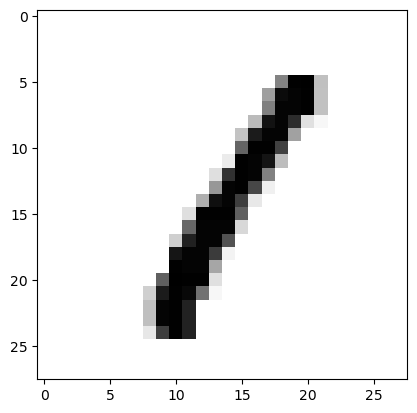

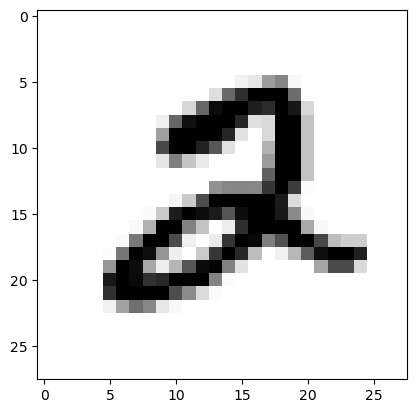

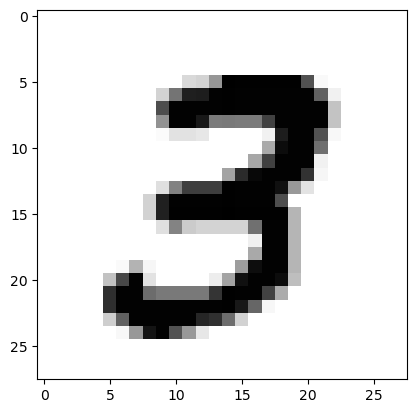

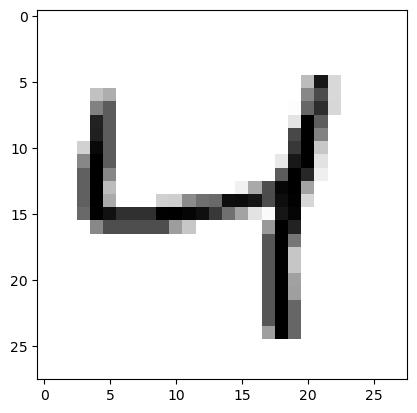

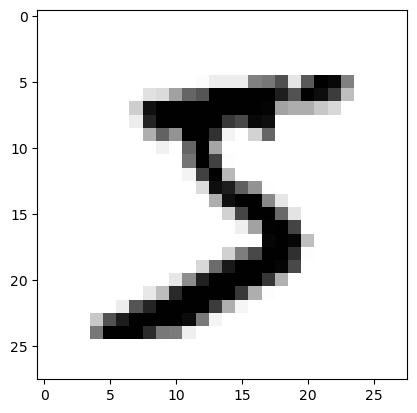

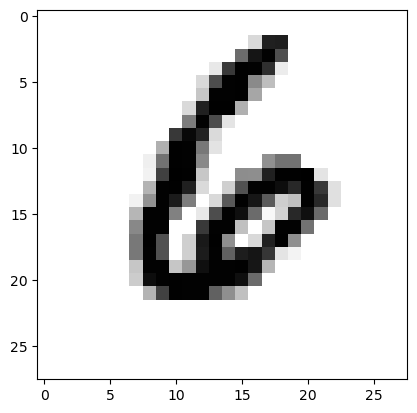

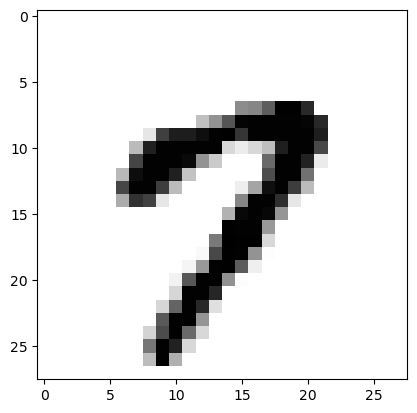

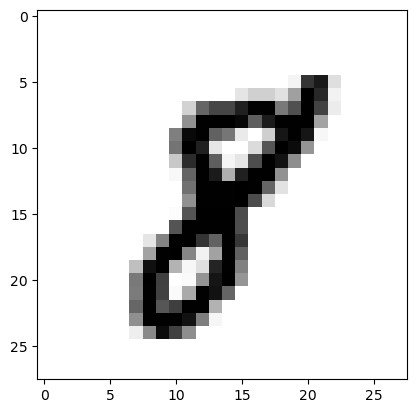

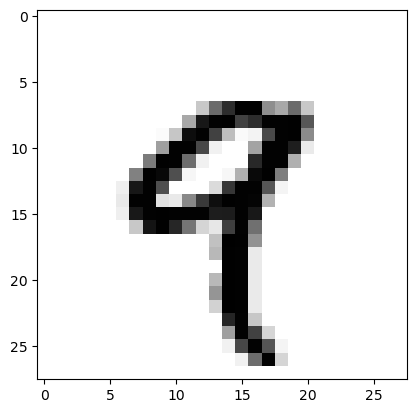

In [3]:
# 2. Display examples of each written number 0-9. 
for i in range(10):
    num_idx = np.where(y_train==i)[0][0]
    plt.imshow(x_train[num_idx], cmap='binary')
    plt.show()

In [4]:
# 3. Proof that you have a representative sample from each class
print("------ Testing Set -------")
for i in range(10):
    n_of_instances = np.where(y_train==i)[0].shape[0]
    print(f"{i}: {n_of_instances}")

print("\n------ Training Set -------")
for i in range(10):
    n_of_instances = np.where(y_test==i)[0].shape[0]
    print(f"{i}: {n_of_instances}")

------ Testing Set -------
0: 5923
1: 6742
2: 5958
3: 6131
4: 5842
5: 5421
6: 5918
7: 6265
8: 5851
9: 5949

------ Training Set -------
0: 980
1: 1135
2: 1032
3: 1010
4: 982
5: 892
6: 958
7: 1028
8: 974
9: 1009


From these counts, we can see that we have at least 100 instances per class in both the training and testing sets. 

---

### **Part 2: Feature Engineering using Eigen Decompoosition (15 points)**
#### **Instructions:**
1. Using `scipy.fft.dct` or `scipy.fftpack.dct` apply the **2D Discrete Cosine Transform** on each 28x28 image.
2. Using the directional masks created using the code below extract the **directional coefficients** from each direction.
3. For each directional component, **flatten the selected masked DCT coefficients** and create a matrix of samples.
4. Compute the covariance matrix and perform **eigen decomposition**
5. For each of the three directions, **retain the top 20 eigenvectors**
6. Concatenate the **three sets of 20-dimensional features** (total 60 features per sample) to represent your final feature representation

#### **Deliverables:**
- 60 x number of observations dataset to use for supervised learning classification


In [5]:
# 1. 2D Discrete Cosine transform
#    Normalize the data between [0,1] (values range btwn 0 and 255, so divide by 255)
x_train = x_train / 255.0
x_test = x_test / 255.0 

#    Apply 2D dct to data
def dct_2d(data):
    return dct(dct(data, axis=1, norm='ortho'), axis=2, norm='ortho')

dct_train = dct_2d(x_train)
dct_test = dct_2d(x_test)


# 2. Extract directional coefficients 
def create_custom_dct_masks(size=28):
      h_mask = np.zeros((size, size), dtype=bool)
      v_mask = np.zeros((size, size), dtype=bool)
      d_mask = np.zeros((size, size), dtype=bool)

      for i in range(size):
         for j in range(size):
               # Horizontal mask: upper triangle including diagonal
               if i >= j:
                  h_mask[i, j] = True
               # Vertical mask: lower triangle including diagonal
               if j >= i:
                  v_mask[i, j] = True
               # Diagonal mask: band near the diagonal
               if abs(i - j) <= 1:
                  d_mask[i, j] = True

      return h_mask, v_mask, d_mask

h_mask, v_mask, d_mask = create_custom_dct_masks()


# 3. Flatten the selected masked DCT coeffs and create matrix of samples 
def mask_and_flatten(dct_data, mask):
    return dct_data[:, mask]

h_train = mask_and_flatten(dct_train, h_mask)
v_train = mask_and_flatten(dct_train, v_mask)
d_train = mask_and_flatten(dct_train, d_mask)

h_test = mask_and_flatten(dct_test, h_mask)
v_test = mask_and_flatten(dct_test, v_mask)
d_test = mask_and_flatten(dct_test, d_mask)


# 4. Compute covariance matrix and perform Eigen Decomposition 
def get_top_k_eigenvectors(features, k=20):
    covariance_matrix = np.cov(features, rowvar=False)
    eig_vals, eig_vecs = eigh(covariance_matrix) 
    return eig_vecs[:, -k:]  # The largest eigenvalues are at the end, so take -k: 


# 5. Retain top 20 eigenvectors
h_top20 = get_top_k_eigenvectors(h_train, 20)
v_top20 = get_top_k_eigenvectors(v_train, 20)
d_top20 = get_top_k_eigenvectors(d_train, 20)


# 6. Concatenate three sets of 20-dimensional features for final feat representation 
h_train_proj = h_train @ h_top20  # @ -> matrix multiplication 
v_train_proj = v_train @ v_top20
d_train_proj = d_train @ d_top20
final_train_features = np.hstack([h_train_proj, v_train_proj, d_train_proj])

h_test_proj = h_test @ h_top20
v_test_proj = v_test @ v_top20
d_test_proj = d_test @ d_top20
final_test_features = np.hstack([h_test_proj, v_test_proj, d_test_proj])

print("Train features shape:", final_train_features.shape)
print("Test features shape:", final_test_features.shape)

Train features shape: (60000, 60)
Test features shape: (10000, 60)


---

### **Part 3: Classification Algorithms (25 Points)**

#### **Instructions:**
1. **Train a supervised classification model** using the reduced feature set generated in **Part 2**. You may use any built-in method from `sklearn` (e.g., KNN, Random Forest, SVM, etc.).  
   - Evaluate model performance (e.g., accuracy, confusion matrix).  
   - **Interpret the model**: What patterns does it learn? Which features seem important?

2. **Train a second model using your own SVM implementation** from Homework 3.  
   - You may choose a **linear or RBF kernel**.  
   - Use the same feature set from Part 2.  
   - Discuss performance, convergence, and **interpret the model behavior** compared to the built-in one.

3. **Compare model performance** between your `sklearn` classifier and your custom SVM.  
   - Use **plots** (accuracy bars, confusion matrices, etc.) and **textual analysis** to highlight key differences.  
   - Consider trade-offs in **accuracy**, **training time**, and **model flexibility**.

4. **Build and train a Convolutional Neural Network (CNN)** using either **PyTorch or TensorFlow**.  
   - Input should be the **raw 28×28 image** (not the reduced feature set).  
   - You may use standard architectures (e.g., 2 convolutional layers + dense layers).  
   - Train and evaluate the CNN on the same subset of data.

5. **Compare and analyze CNN vs. DCT-based models.**  
   - Report the **accuracy of all three models** (built-in, custom SVM, CNN).  
   - Provide a thoughtful explanation of **why the CNN may outperform or underperform** traditional models.  
   - Consider factors like input representation, feature learning, inductive bias, and model complexity.

#### **Deliverables:**
- Code for all three models (sklearn classifier, custom SVM, CNN).
- Accuracy reports and visual comparisons (e.g., bar charts, confusion matrices).
- A short written analysis comparing performance, highlighting **why results differ**, **algorithm complexity**, and discussing **model interpretability** vs. accuracy.



Random Forest Accuracy: 0.9604
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.96      0.97      0.96       982
           5       0.96      0.95      0.95       892
           6       0.97      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.93      0.94       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 965    0    2    0    0    2    6    1    4    0]
 [   0 1124    3    1    0    0    4    1    2    0]
 [   6    0  996    6    2    2    2    8   10    0]
 [   0    0   10  959    0   16    1    8   11    5

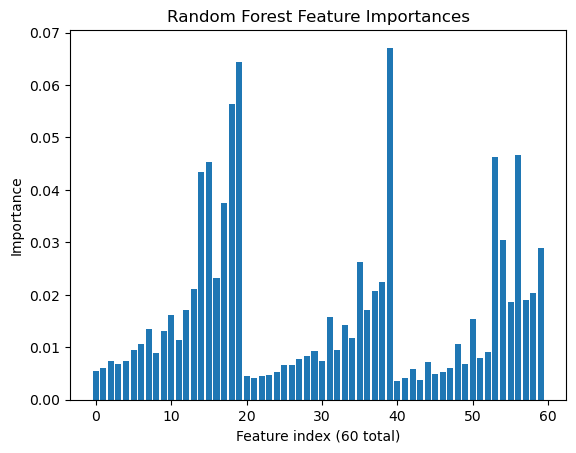

Top 20 Features with Importance values:


,Feature Index,Importance
39,39,0.067102
19,19,0.064474
18,18,0.056375
56,56,0.046565
53,53,0.046304
15,15,0.045318
14,14,0.043429
17,17,0.037592
54,54,0.030431
59,59,0.028875


In [6]:
# 1. Train a supervised classification model. My choice: Random Forest 
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1  # use all CPU cores
)
rf_clf.fit(final_train_features, y_train)

y_pred = rf_clf.predict(final_test_features)

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, y_pred))
rf_cm = confusion_matrix(y_test, y_pred)
print(rf_cm)
rf_cm_df = pd.DataFrame(rf_cm, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


importances = rf_clf.feature_importances_
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature index (60 total)")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()

# Create a simple table with feature index and importance value
df_importances = pd.DataFrame({
    'Feature Index': range(len(importances)),
    'Importance': importances
})

# Sort by importance descending (optional)
df_importances = df_importances.sort_values(by='Importance', ascending=False)

print(f"Top 20 Features with Importance values:")
display(df_importances.iloc[:20])

From this, we can see that the model is learning to determine/classify digits based on frequency patterns in the three directions (horizontal, vertical, diagonal).The top 20 eigenvectors we kept capture the most variance in these frequency bands. We can think of these as shapes and strokes that are common to each digit. So essentially, the model is using these frequency-based patterns rather than raw pixel intensities to classify the input digits.   
       
The top 10 most important features are 39, 19, 18, 53, 56, 15, 14, 17, 54, and 59. It is interesting to note that in each set of 20 features, the feature importances tend to increase. 

In [7]:
# 2. Train a model using custom SVM from HW 3 

# --- SVM --- 
def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)

def train_svm(X, y, kernel='linear', gamma=1.0):
    X = np.array(X)
    y = np.array(y) 
    
    n_samples, n_features = X.shape

    # K = np.dot(X, X.T)
    if kernel == "linear":
        K = linear_kernel(X, X)
    # elif kernel == "rbf":
    #     K = rbf_kernel(X, X, gamma)
    else:
        raise ValueError("Unsupported kernel")
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))

    # Constraining inequality matrices
    C = 1.0
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))

    # Equality constraint matrices
    A = matrix(y.reshape(1, -1).astype('double'))
    b = matrix(np.zeros(1))

    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x']).flatten()

    support_vectors = alphas > 1e-5
    support_vector_indices = np.where(support_vectors)[0]
    alpha_sv = alphas[support_vectors]
    X_sv = X[support_vectors]
    y_sv = y[support_vectors]

    # Weights and biases 
    w = np.sum(alpha_sv[:, None] * y_sv[:, None] * X_sv, axis=0)

    # Compute bias (use first support vector)
    b = np.mean(y_sv - np.dot(X_sv, w))

    return w, b, support_vector_indices


def predict_svm(X, w, b):
    return np.sign(np.dot(X, w) + b)



y_train_bin = np.where(y_train == 0, 1, -1)
y_test_bin = np.where(y_test == 0, 1, -1)

# Training on 2000 samples bc the whole dataset is crashing my computer 
X_train_small = final_train_features[:5000]
y_train_small = y_train_bin[:5000]



In [15]:
# Train your custom linear SVM on binary task
w, b, sv_idx = train_svm(X_train_small, y_train_small, kernel='linear')
print(f"Support vectors count: {len(sv_idx)}")

# Predict
y_pred_bin = predict_svm(final_test_features, w, b)

# Evaluate
svm_accuracy = accuracy_score(y_test_bin, y_pred_bin)
print(f"Custom binary SVM Accuracy (digit 0 vs rest): {svm_accuracy:.4f}")
svm_cm = confusion_matrix(y_test_bin, y_pred_bin)
svm_cm_df = pd.DataFrame(svm_cm, index=[0, 1], columns=[0, 1])
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_bin))

     pcost       dcost       gap    pres   dres
 0: -5.1294e+02 -1.0109e+04  6e+04  3e+00  4e-12
 1: -3.2835e+02 -5.6557e+03  1e+04  4e-01  4e-12
 2: -2.1214e+02 -2.1283e+03  3e+03  1e-01  2e-12
 3: -1.6192e+02 -1.4135e+03  2e+03  7e-02  2e-12
 4: -1.3382e+02 -1.0779e+03  2e+03  5e-02  1e-12
 5: -1.1152e+02 -7.4074e+02  1e+03  3e-02  1e-12
 6: -9.3959e+01 -5.4638e+02  8e+02  2e-02  8e-13
 7: -8.1580e+01 -4.1469e+02  6e+02  1e-02  7e-13
 8: -7.0354e+01 -3.4095e+02  5e+02  8e-03  6e-13
 9: -6.4540e+01 -2.5023e+02  3e+02  5e-03  6e-13
10: -6.2171e+01 -1.8511e+02  2e+02  3e-03  5e-13
11: -5.9734e+01 -1.2656e+02  9e+01  9e-04  6e-13
12: -6.2163e+01 -9.1123e+01  3e+01  1e-04  6e-13
13: -6.3991e+01 -8.5380e+01  2e+01  7e-05  6e-13
14: -6.6093e+01 -7.9502e+01  1e+01  2e-05  6e-13
15: -6.8616e+01 -7.4385e+01  6e+00  1e-06  7e-13
16: -7.0115e+01 -7.2343e+01  2e+00  5e-07  7e-13
17: -7.0295e+01 -7.1977e+01  2e+00  2e-07  7e-13
18: -7.0836e+01 -7.1331e+01  5e-01  2e-08  7e-13
19: -7.1036e+01 -7.11

There are notable differences between my custom SVM and the built-in Random Forest. My custom SVM gives good interpretability, especially in classification with low-dimensional features like the reduced-dimension DCT vectors. However, it struggles with scalability. I was unable to computing the full kernel matrix for the original 60,000 samples -- this would have consumed about 28 GB of memory, and crashed my kernel when I tried to run it. Additionally, my custom SVM does not natively support multiclass classification. This is a functionality I would like to build in at some point. The built-in Random Forest is much more memory-efficient and natively support multiclass classification. It can handle the 60,000 observations in the full MNIST dataset and requires little preprocessing. The RF is also robust to noise and outliers. While SVMs provide interpretable weights for each feature, Random Forests give good performance with minimal tuning. I would say that for small-scale binary tasks, the SVM is valuable. For large-scale or more real-wrold/practical applications, the built-in Random Forest would be a better option. 

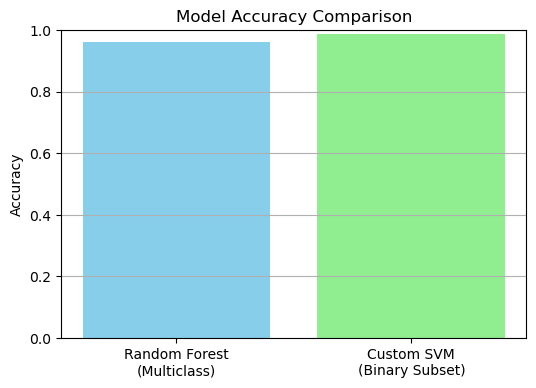

In [9]:
# 3. Compare model performance between RF and custom SVM 
plt.figure(figsize=(6, 4))
plt.bar(['Random Forest\n(Multiclass)', 'Custom SVM\n(Binary Subset)'], [rf_accuracy, svm_accuracy], color=['skyblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

Here we can see that the custom SVM actually had a slightly higher accuracy than the built-in RF. However, it took longer to train and is less memory efficient.

In [10]:
# 4. Train a CNN on raw data 
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape to proper shape and normalize
x_train = x_train.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

# Convert np.arrays to torch tensors
train_images = torch.tensor(x_train)
train_labels = torch.tensor(y_train)
test_images = torch.tensor(x_test)
test_labels = torch.tensor(y_test)

# Create datasets and dataloaders
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define CNN model architecture 
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Specify device, model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.2111
Epoch 2/10, Loss: 0.0617
Epoch 3/10, Loss: 0.0428
Epoch 4/10, Loss: 0.0336
Epoch 5/10, Loss: 0.0268
Epoch 6/10, Loss: 0.0214
Epoch 7/10, Loss: 0.0186
Epoch 8/10, Loss: 0.0149
Epoch 9/10, Loss: 0.0108
Epoch 10/10, Loss: 0.0099


In [11]:
# Evaluate the model 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cnn_accuracy = accuracy_score(all_labels, all_preds)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")
cnn_cm = confusion_matrix(all_labels, all_preds)
cnn_cm_df = pd.DataFrame(cnn_cm, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

CNN Test Accuracy: 0.9909


,model,accuracy
0,built_in_rf,0.9604
1,custom_svm,0.9887
2,torch_cnn,0.9909


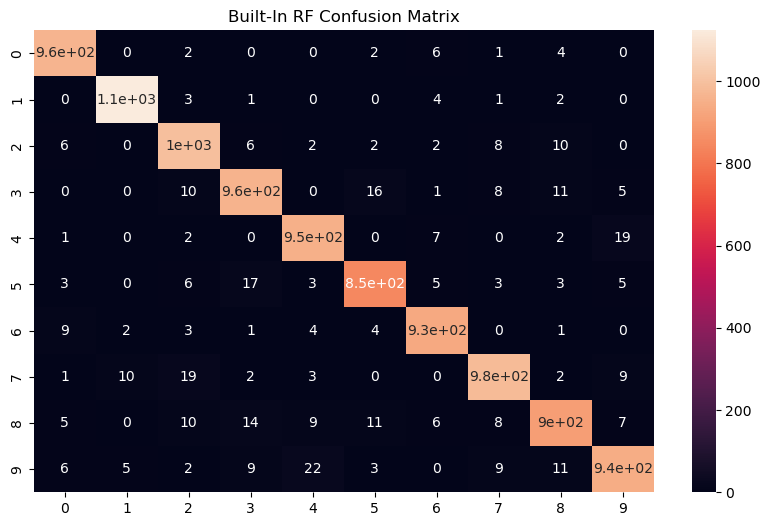

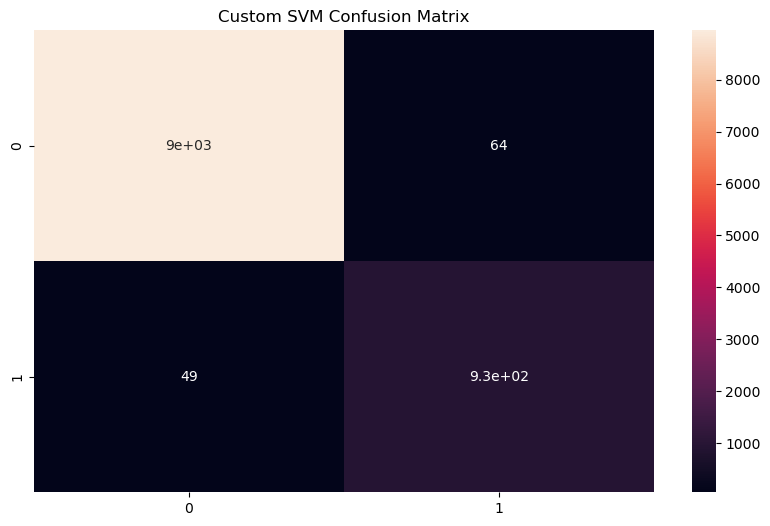

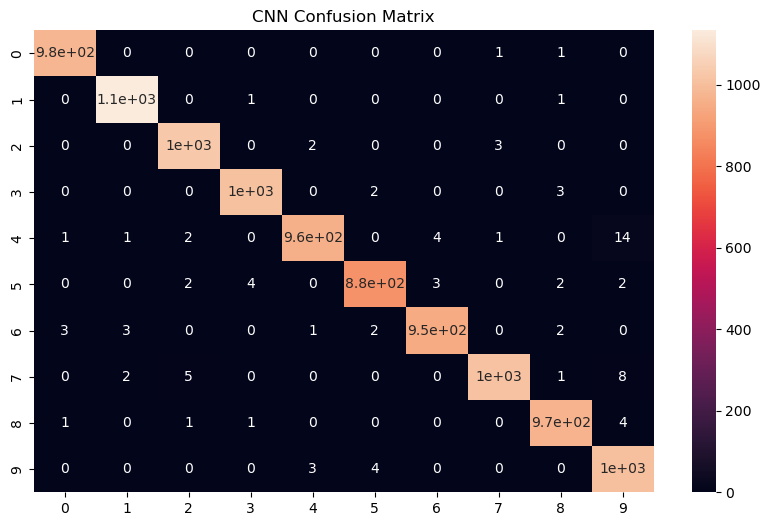

In [16]:
# 5. Compare and analyze CNN vs DCT models 
accuracy_df = pd.DataFrame({"model": ["built_in_rf", "custom_svm", "torch_cnn"],
                            "accuracy": [rf_accuracy, svm_accuracy, cnn_accuracy]})
display(accuracy_df)

# Confusion matrices 
fig = plt.figure(figsize=(10, 6))
sns.heatmap(rf_cm_df, annot=True)
plt.title("Built-In RF Confusion Matrix")
plt.show()

fig = plt.figure(figsize=(10, 6))
sns.heatmap(svm_cm_df, annot=True)
plt.title("Custom SVM Confusion Matrix")
plt.show()

fig = plt.figure(figsize=(10, 6))
sns.heatmap(cnn_cm_df, annot=True)
plt.title("CNN Confusion Matrix")
plt.show()

Note: For my custom SVM, I was running into memory issues when trying to train on the full 60,000 samples in the dataset so I downsampled to 5,000. Additionally, because the SVM I developed in HW3 was for binary classification, the metric I used here measured how well the model could discriminate a 0 from the other 9 digits. While this is not an exact apples-to-apples comparison with the other models, I thought it would be a good starting point. In the future I would like to adapt the SVM I built in HW 3 to be a multi-class classifier. 

---

From the accuracies of the three models, we can see that while all perform well, the CNN performs the best. We can also see that the confusion matrix of the CNN shows it performs the best. It has the smallest off-diagonal values, and the highest on-diagonal values. This indicates that it is misclassifying less of the test data points than the other models. 

Input representation     
The traditional methods require the input to be flattened(e.g., 28x28 image -> 784-dimensional vector) which loses the spatial structure of the data (location of pixels, edges, shapes). This may cause the classifier to be unable to distinguish between small local patterns and larger global structures. The CNN can take multi-dimensional tensors (e.g., 1x28x28) as input to the model. This retains the spatial information in the data. This allows the CNN to detect features like edges, corners, textures in the data to recognize structures in the images.

Feature Learning        
In the DCT-based models, we hand-engineered the feature sets that are input into the models for training. This may result in the model having difficulty generalizing unless the features are very well chosen. The CNN learns features automatically during training, the earlier layers learn low-level features like edges and corners, while the deeper layers learn more high-level abstractions. It is possible that the CNN can find meaningful features/patterns within the data that were not captured in the DCT-based engineered feature sets. 

Inductive Bias        
The CNN has inductive bias (certain assumptions about the data). These include assuming that nearby pixels are more related than distant ones, filters/kernels are reused across the entire input (which indicates that the same patterns can appear in different locations), and pooling and convolutions allow the model to recognize patterns no matter their position. These allow the CNN to learn with fewer parameters and data than other networks would need. 

Model Complexity         
The DCT-based/traditional models tend to have fewer parameters than the CNN. This makes the model simpler, more interpretable, and faster to train. However, this limits the models generalizability. It may not scale well with high-dimensional input and may result in the model easily overfitting without regularization or feature selection. The CNN can have significantly more parameters. This makes CNNs computationally expensive to train, but they can scale/generalize better to complex patterns given sufficient data. 

Given these reasons, this is why the CNN may perform better than traditional methods, especially for high-dimentional spatial data like an image. 


---

### **Key Considerations**
✅ **Logical Flow:** The problem follows a structured pipeline: **Image Reshaping → DCT Feature Extraction → Masking → Eigen Decomposition → Classification**  
✅ **Feature Engineering Emphasis:** Focuses on building compact, informative features using **directional DCT coefficients** and **eigenvectors**, not just using raw pixels.  
✅ **Algorithmic Thinking:** Requires understanding of **signal processing**, **linear algebra** (e.g., eigen decomposition, projections), and **classification pipelines**.    
✅ **Model Comparison:** Involves evaluating and comparing **sklearn models**, a **custom SVM**, and a **CNN**, encouraging reflection on strengths of different classification algorithms.


## Question 2: Design of Experiments (25 Points Total)


In the next cells you’ll be provided with code that defines the initial ground object box (with latitude and longitude boundaries) and runs the simulation. 

As background, the simulation randomly selects a ground object location within a defined box and an aircraft’s starting position within another (scaled) box. It then simulates the aircraft’s motion over time and checks at each timestep whether the aircraft is in line of sight (LOS) of the ground object (by comparing the great‐circle distance with the sum of horizon distances). 

The outcome is recorded as a binary **“target”** variable:  
- `0` for detection (LOS exists)  
- `1` for no detection (no LOS)

> **Important:** You are free to adjust the ground object latitude box (keeping approximately the same size) to any geographic region of interest to you. This will allow you to explore the effects of location on LOS detection.

Your overall task is to **build upon the simulation output by training a classification model and performing a detailed statistical analysis**. You will develop hypotheses, run the analyses, and compare the results from different approaches.

Your answers should include:
- Code
- Outputs (e.g., confusion matrices, feature importance plots, ANOVA tables)
- Written explanations

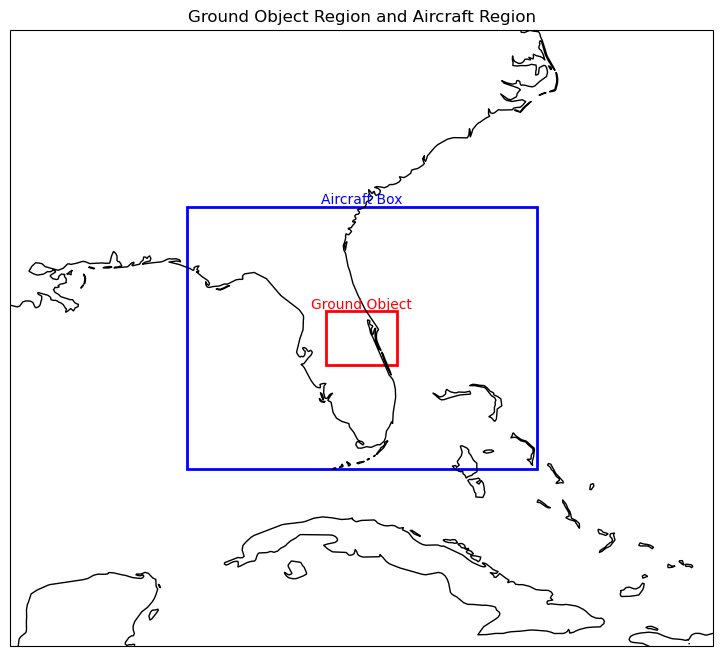

In [17]:
import math
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import pandas as pd

# -----------------------
# Define the Ground Object box (ground object region)
# -----------------------
ground_lon_min, ground_lat_min = -82, 27.5
ground_lon_max, ground_lat_max = -80, 29.0
ground_width = ground_lon_max - ground_lon_min  # 2.0 degrees
ground_height = ground_lat_max - ground_lat_min   # 1.5 degrees

# Compute the center of the ground box
center_lon = (ground_lon_min + ground_lon_max) / 2
center_lat = (ground_lat_min + ground_lat_max) / 2

# -----------------------
# Define the Aircraft bounding box (30% smaller than the 50x area box)
# -----------------------
# Scale up dimensions for a 50x area then reduce by 30%
scale_factor = 50**0.5
aircraft_width = ground_width * scale_factor * 0.7
aircraft_height = ground_height * scale_factor * 0.7

# Center the aircraft box on the ground box center.
aircraft_lon_min = center_lon - aircraft_width / 2
aircraft_lon_max = center_lon + aircraft_width / 2
aircraft_lat_min = center_lat - aircraft_height / 2
aircraft_lat_max = center_lat + aircraft_height / 2

# -----------------------
# Visualization: Plotting Both Boxes
# -----------------------
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add geographic features.
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Draw the Ground Object box (red).
ground_rect = mpatches.Rectangle(
    (ground_lon_min, ground_lat_min),
    ground_width,
    ground_height,
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(ground_rect)
ax.text((ground_lon_min + ground_lon_max) / 2, ground_lat_max,
        "Ground Object", color='red',
        ha='center', va='bottom', transform=ccrs.PlateCarree())

# Draw the Aircraft bounding box (blue).
aircraft_rect = mpatches.Rectangle(
    (aircraft_lon_min, aircraft_lat_min),
    aircraft_width,
    aircraft_height,
    linewidth=2,
    edgecolor='blue',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(aircraft_rect)
ax.text((aircraft_lon_min + aircraft_lon_max) / 2, aircraft_lat_max,
        "Aircraft Box", color='blue',
        ha='center', va='bottom', transform=ccrs.PlateCarree())

# Set the extent to show both boxes with a margin.
margin_lon = 5
margin_lat = 5
ax.set_extent([aircraft_lon_min - margin_lon, aircraft_lon_max + margin_lon,
               aircraft_lat_min - margin_lat, aircraft_lat_max + margin_lat],
              crs=ccrs.PlateCarree())

plt.title("Ground Object Region and Aircraft Region")
plt.show()

In [18]:
import math
import random
import pandas as pd

# Earth's radius in meters
R = 6371000

# Simulation parameters
total_time = 3600  # seconds (1 hour)
dt = 10            # time step in seconds
num_steps = total_time // dt

# Number of simulation runs
num_runs = 10000

# -----------------------
# Helper Functions
# -----------------------
def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two points (in meters)."""
    lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
    lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

def update_position(lat, lon, speed, heading, dt):
    """
    Update position based on current lat/lon, speed (m/s), heading (degrees),
    and time step dt. Uses a simple spherical approximation.
    """
    distance = speed * dt
    heading_rad = math.radians(heading)
    delta_north = distance * math.cos(heading_rad)
    delta_east = distance * math.sin(heading_rad)
    delta_lat = (delta_north / R) * (180 / math.pi)
    delta_lon = (delta_east / (R * math.cos(math.radians(lat)))) * (180 / math.pi)
    new_lat = lat + delta_lat
    new_lon = lon + delta_lon
    new_lon = (new_lon + 180) % 360 - 180  # normalize longitude
    new_lat = max(min(new_lat, 90), -90)   # constrain latitude
    return new_lat, new_lon

def horizon_distance(alt):
    """
    Calculate the horizon distance (in meters) for a given altitude 'alt'
    using the approximation: distance ≈ √(2 * R * alt)
    """
    return math.sqrt(2 * R * alt)

# -----------------------
# Simulation Function
# -----------------------
def simulate_run():
    # Choose a random ground object location within the ground box.
    ground_lon = random.uniform(ground_lon_min, ground_lon_max)
    ground_lat = random.uniform(ground_lat_min, ground_lat_max)
    ground_alt = 1.5  # observer height in meters

    # Choose a random aircraft initial position within the aircraft bounding box.
    init_plane_lat = random.uniform(aircraft_lat_min, aircraft_lat_max)
    init_plane_lon = random.uniform(aircraft_lon_min, aircraft_lon_max)

    # Randomly select the aircraft altitude between 150 ft and 65,000 ft (converted to meters).
    plane_alt = random.uniform(150 * 0.3048, 65000 * 0.3048)

    # Aircraft speed and heading.
    plane_speed = 250  # m/s (~900 km/h)
    plane_heading = random.uniform(0, 360)  # degrees

    # Set initial aircraft position.
    plane_lat = init_plane_lat
    plane_lon = init_plane_lon

    # Flag for line-of-sight occurrence.
    los_occurred = False

    for step in range(int(num_steps) + 1):
        # Calculate the great-circle distance between ground object and aircraft.
        distance = haversine(ground_lat, ground_lon, plane_lat, plane_lon)
        # Calculate horizon distances.
        d_ground = horizon_distance(ground_alt)
        d_plane = horizon_distance(plane_alt)
        # If LOS exists at this timestep, flag it.
        if distance <= (d_ground + d_plane):
            los_occurred = True
            break
        # Update aircraft position.
        plane_lat, plane_lon = update_position(plane_lat, plane_lon, plane_speed, plane_heading, dt)

    # If LOS occurred at least once, target is 0, otherwise 1.
    target = 0 if los_occurred else 1

    return {
        "ground_lat": ground_lat,
        "ground_lon": ground_lon,
        "ground_alt": ground_alt,
        "init_plane_lat": init_plane_lat,
        "init_plane_lon": init_plane_lon,
        "plane_alt": plane_alt,
        "plane_speed": plane_speed,
        "plane_heading": plane_heading,
        "target": target
    }

# -----------------------
# Run the Simulation and Save Results in a DataFrame
# -----------------------
results = [simulate_run() for _ in range(num_runs)]
df = pd.DataFrame(results)

# Calculate the fraction of runs with target = 1 (i.e. no LOS ever occurred)
fraction_no_los = df["target"].mean()
print(f"Fraction of runs with no LOS (target=1): {fraction_no_los:.4f}")
print("\nDataFrame head:")
print(df.head())


Fraction of runs with no LOS (target=1): 0.3896

DataFrame head:
   ground_lat  ground_lon  ground_alt  init_plane_lat  init_plane_lon  \
0   28.658113  -80.055771         1.5       28.424866      -76.381867   
1   27.811308  -81.497794         1.5       28.049299      -85.298053   
2   28.179736  -80.175217         1.5       29.333759      -85.694980   
3   28.134132  -80.085110         1.5       31.557238      -84.527438   
4   28.624144  -80.817984         1.5       27.196506      -79.846142   

      plane_alt  plane_speed  plane_heading  target  
0   2659.529647          250       6.806622       1  
1   3347.975317          250      88.962366       0  
2  16920.060370          250      33.549057       1  
3   6461.732150          250     254.198011       1  
4   3060.221536          250     136.181019       0  


---

## Part 1: Background and Hypothesis (5 points)

**Question:**  
Briefly describe, in your own words, what the simulation code is doing. Your explanation should cover:

- How the simulation uses geographic bounding boxes to set up the ground object and aircraft positions.
- How the simulation determines if LOS exists between the ground object and the aircraft.
- What the “target” variable represents.

**Additionally:**  
Propose a **hypothesis** about which parameters (e.g., aircraft altitude or initial aircraft longitude) you expect to have the greatest influence on LOS detection, and briefly justify your reasoning.

> **Note:** You do not need to fully understand every detail of the simulation code, focus on the overall purpose and mechanism as described above. Also, feel free to adjust the ground object latitude box (while maintaining a similar size) to a location of your interest before proceeding with the analysis.

**How the simulation uses geographic bounding boxes**     
The simulation code is uses geographic bounding boxes to set up two geographic areas that are defined by longitude and latitude limits. The first geographic area is the ground object box. This is a smaller rectangle that defines where the ground observer can be located. The second is the aircraft bounding box. This is the larger rectangle that is centered on the ground box but is scaled such that it covers a larger area where the aircraft position can be. The simulation then chooses random positions for the ground object and the aircraft within each of their respective bounding boxes. This is how it simulates different scenarios.      

**Determining if Line-of-Sight (LOS) exists**       
At each simulation time step, the code calculates the great-circle distance between the ground object and the aircraft using the haversine formula. It also calculates the horizon distances for both based on their altitudes and Earth's radius. LOS is said to exist if the distance between the two is less than or equal to the sum of their horizon distances. This means that the aircraft is above the horizon line from the perspective of the ground object. The aircraft position is updated each time step based on its speed and heading to simulate movement. If LOS is detected at any time step, the simulation marks that run as having LOS.      

**What the target variable represents**       
The target variable represents whether LOS has never occurred during the simulation run (target = 1) or if LOS occurred at least once (target = 0). So, target = 1 means no LOS was ever detected for that run, and target = 0 means LOS was detected at least once.

**Hypothesis proposal**    
I hypothesis that the aircraft altitude will have the greatest influsence on LOS detection. This is because the horizon distance increases approximately with the square root of the altitude, meaning higher aircraft can be seen from farther away. The aircraft's initial longitude and latitude might affect how quickly/if it enters the LOS zone, but altitude directly affects how far the aircraft can be seen over the horizon regardless of location. Therefore, changes in altitude are likely to be the most significant factor in whether LOS occurs.

---

## Part 2: Building a Classification Model (7 points)

**Question:**  
Using the simulation output (stored in a DataFrame named `df` with columns including:

- `ground_lat`, `ground_lon`, `ground_alt`
- `init_plane_lat`, `init_plane_lon`
- `plane_alt`, `plane_speed`, `plane_heading`
- `target`

Complete the following tasks:

1. Separate the features (`X`) and the target variable (`y`).
2. Split the data into an 80-20 train-test split.
3. Train a **Random Forest classifier** on the training set.
4. Evaluate the model by computing the **accuracy** on both the training and test sets and **visualizing the confusion matrices**.

**Discussion:**  
Explain your **initial hypothesis** regarding which features might most strongly influence LOS detection, and comment on whether your model’s performance and the confusion matrices align with your expectations.

---- Performance on TRAIN set ----
Accuracy: 1.0


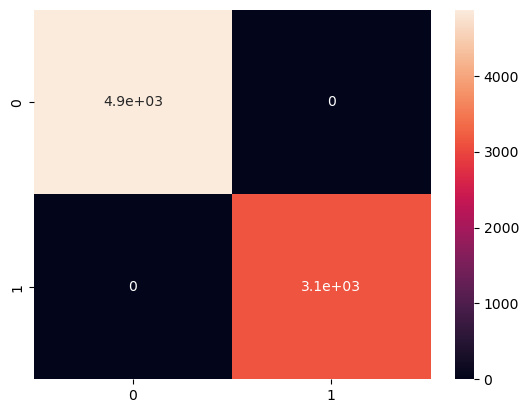

---- Performance on TEST set ----
Accuracy: 0.912


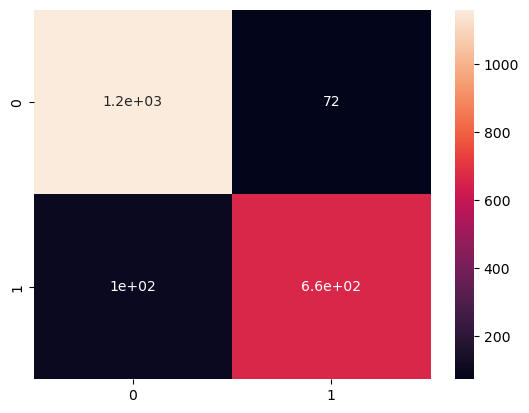

In [19]:
# 1. Separate the features and target variables
X = df.drop(columns=['target'])
y = df['target']

# 2. Split the training data into 80-20 train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train a Random Forest classifier 
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

# 4. Evaluate the model with accuracy & confusion matrices 
print("---- Performance on TRAIN set ----")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train)}")
cm = confusion_matrix(y_train, y_pred_train)
class_labels = np.unique(y_train)  # Get unique class labels
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True)
plt.show()


print("---- Performance on TEST set ----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
cm = confusion_matrix(y_test, y_pred_test)
class_labels = np.unique(y_test)  # Get unique class labels
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True)
plt.show()

In [20]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Ranked Feature Importances:")
display(sorted_feature_importance)

Ranked Feature Importances:


,Feature,Importance
5,plane_alt,0.313324
4,init_plane_lon,0.222634
3,init_plane_lat,0.156823
7,plane_heading,0.145260
1,ground_lon,0.084555
0,ground_lat,0.077404
2,ground_alt,0.000000
6,plane_speed,0.000000


From the feature importance list above (sorted as most important to least important), we can see that the plate_alt is the most important feature. This reconciles perfetly with my hypothesis that the aircraft's altitude would be the most important/have the largest affect on whether LOS can be established. It is interesting to note that the model performs perfectly when evaluated on the training set (accuracy = 1). The confusion matrix for evaluation on the training set shows the perfect performance; 0 data observations were misclassified (off-axis values are 0 in the CM). These may indicate that overfitting may have occurred -- the model may have memorized the training data. However, the accuracy is 0.9085 on the test set. This shows that the model was able to generalize well to data it has never seen before. The confusion matrix also shows the imperfect but very good performance of the classifier. The results align with my expectations. Good performance generalization, and aircraft position is important for LOS. 

---

## Part 3: Performing ANOVA and Logistic Regression (7 points)

**Question:**  
Using the `statsmodels` module, perform a **statistical analysis** on the training data by:

1. Fitting an **Ordinary Least Squares (OLS)** model using a formula that includes all the features (e.g.,  
   `target ~ ground_lat + ground_lon + ground_alt + init_plane_lat + init_plane_lon + plane_alt + plane_speed + plane_heading`)  
   and generating an **ANOVA table**.

2. Fitting a **logistic regression model** (which is more appropriate for binary outcomes) with the same formula.

3. Reporting and comparing the results, particularly highlighting **which features are statistically significant** in both models.

**Discussion:**  
Formulate a **hypothesis** on which features you expect to be statistically significant in explaining LOS detection. Explain how the ANOVA and logistic regression results support or contradict your hypothesis.

In [21]:
# 1. Fit OLS and generate ANOVA table 
formula = "target ~ ground_lat + ground_lon + ground_alt + init_plane_lat + init_plane_lon + plane_alt + plane_speed + plane_heading"

ols_model = smf.ols(formula, data=X_train.assign(target=y_train)).fit()
anova_results = anova_lm(ols_model)

print("ANOVA table for OLS model:")
print(anova_results)

ANOVA table for OLS model:
                    df       sum_sq     mean_sq            F    PR(>F)
ground_lat         1.0     0.917698    0.917698     5.028143  0.024966
ground_lon         1.0     0.015613    0.015613     0.085543  0.769929
ground_alt         1.0     0.166067    0.166067     0.909894  0.340171
init_plane_lat     1.0     0.560657    0.560657     3.071890  0.079695
init_plane_lon     1.0     0.038723    0.038723     0.212166  0.645087
plane_alt          1.0   444.876042  444.876042  2437.514061  0.000000
plane_speed        1.0     0.000022    0.000022     0.000122  0.991198
plane_heading      1.0     0.009938    0.009938     0.054451  0.815497
Residual        7993.0  1458.819976    0.182512          NaN       NaN


In [22]:
# 2. Fit logistic regression model 
logit_model = smf.logit(formula, data=X_train.assign(target=y_train)).fit()
print("\nLogistic Regression Summary:")
print(logit_model.summary())

print("\nSignificant features in logistic regression (p < 0.05):")
significant_features = logit_model.pvalues[logit_model.pvalues < 0.05]
print(significant_features)


         Current function value: 0.541241
         Iterations: 35

Logistic Regression Summary:
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7992
Method:                           MLE   Df Model:                            7
Date:                Mon, 11 Aug 2025   Pseudo R-squ.:                  0.1913
Time:                        16:35:00   Log-Likelihood:                -4329.9
converged:                      False   LL-Null:                       -5354.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.973e-05        nan        nan        nan         nan         nan
ground_lat        -0.06

/Users/lomusse1/anaconda3/envs/en-685-621/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3. Report and compare results & discussion

As stated above, I hypothesize that plane_alt to be statistically significant because altitude directly affects horizon distance and thus LOS likelihood. Initial aircraft location features like init_plane_lat, init_plane_lon might also be relevant since they affect whether the aircraft starts inside or outside LOS range. Features like ground altitude or speed may have less influence. From the results above, we can see that the ANOVA table from the OLS and the Logistic Regression summary table confirm that plane_alt is statisticlly significant. From the OLS ANOVA table, we can see that the plane_alt feature has the lowest PR(>F) value (or p-value) by far. It is essentially 0, indicating that it is the feature that contributes to establishing LOS most significantly. We also see that the initial plane location features are not as statistically significant as I would hve expected.  The Logistic Regression table also shows us that plane_alt is the most important. It has the smallest standard error, and was chosen as the most significant feature with p \< 0.05. Overall, both the OLS ANOVA table and the Logistic Regression summary confirm my hypothesis that the plane altitude is the most important for establishing LOS, and plane_alt is statstically significant in both models. 

---

## Part 4: Comparative Analysis and Critical Discussion (6 points)

**Question:**  
Compare the insights obtained from your **Random Forest classifier** (particularly the feature importance scores) with the findings from your **ANOVA table** and **logistic regression summary**. Address the following:

- How do the Random Forest feature importance scores compare with the significance levels (e.g., p-values) from the ANOVA and logistic regression outputs?
- What do these comparisons reveal about the key parameters affecting LOS detection in the simulation?
- Based on your analysis, propose potential improvements to the simulation or suggest further experiments to enhance understanding of LOS detection.

**Discussion:**  
In your written analysis, clearly state your **conclusions**, supporting them with **evidence** from your code outputs and plots. Make sure your discussion is well-reasoned and data-driven.

The Random Forest feature importance scores match up fairly well with the significance levels from the ANOVA and logistic regression outputs. The RF determined that the plane altitude is the most important feature that contributes to LOS detection. The OLS ANOVA identified the plane altitude as the most statitstically significant feature, as did the Logistic Regression. Both the OLS ANOVA and the Logistic Regression picked out only plane altitude as being statistically significant. I found this interesting, as the RF feature importances indicated that tghe initila plane longitude position as also being important (init_plane_lon	importance is 0.227650, while plane_alt importance is 0.299095). I found this very interesting -- had I just looked at the RF feature importances, I would have been led to believe that the initial plane longitude location is nearly as important as the plane altitude (intuitively this does not make sense). Given the information from the other two models, it was made clear that the init_plane_lon is, in fact, not as important as the plane altitude. It was good to see that all three methods agree that plane_alt is the most important factor in establishing LOS. 

The comparison between RF importance, and the ANOVA and Logistic Regression significances reveal that the aircraft's altitude is the key factor in achieving LOS. The plane_alt drives the overall geometry of the problem: higher altitude increases likelihood of LOS because of reduced obstruction from Earth's curvature and terrain. This makes intuitive sense. It also reveals that features like heading, lat/lon, or speed may have conditional or localized effects (e.g., heading may matter near terrain or other obstacles) but they dont impact the LOS globally/broadly. 

Some potential improvements to the simulation could be to improve terrain modeling by adding in varying terrain elevation to simulate valleys, hills, buildings, which may force other features like heading/lat/lon to matter more. We could also improve modeling of atmospheric effects that may contribute to refraaction which may affect LOS ability. Another potential improvement could be to include some time-dependent factors like simulating the movement of both the plane and the ground target over time. This may cause speed, heading, and path curvature to contribute more.

## Question 3: Generative Models & Sequence Architectures in NLP (25 Points Total)

### **Objective**  
This question explores modern generative modeling techniques and neural architectures used for sequence data. The focus is on understanding **how GANs, VAEs, and Seq2Seq models**, how they are trained, and how they handle **discrete language data**. You will analyze their design and evaluate basic implementations using pre-trained or lightweight models via **HuggingFace** or **TensorFlow Hub**.

- **Topics Covered:** Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), Sequence-to-Sequence (Seq2Seq) models  
- **Focus Areas:** Basic architectural understanding, loss function comparison, implementation insight, and training strategy analysis

---

### **Part 1: Model Comparison and Demonstration (25 Points)**

#### **Instructions:**
1. **Select two model classes** from the list below:
   - GANs (e.g., TextGAN, SeqGAN)
   - VAEs (e.g., VAE for text generation)
   - Seq2Seq (e.g., encoder-decoder with attention)

2. For each selected model, do the following:

   - **(5 pts)** **Load and demonstrate a pre-trained model** using either [🤗 HuggingFace Transformers](https://huggingface.co/models) or [TensorFlow Hub](https://tfhub.dev/).  
     - Run the model on a sample text input.  
     - Show the generated output or the model's prediction.  
     - Briefly explain how the input and output are represented.

   - **(5 pts)** Describe the model architecture in your own words. What are the key layers (e.g., encoder/decoder, attention, positional encoding)? What role does each play?

   - **(5 pts)** Identify and explain the **loss function** used for training. How does it handle discrete or sequential data?

   - **(5 pts)** Discuss one **challenge in training** this model on text (e.g., instability, exposure bias, overfitting) and a technique used to mitigate it.

3. **(5 pts)** Write a short comparison paragraph (150–250 words) addressing the following:
   - What kinds of tasks is each model better suited for?
   - Which model is more interpretable or efficient?
   - Which is easier to fine-tune or deploy?

#### **Deliverables:**
- Code cells demonstrating the two selected models (using HuggingFace or TensorFlow Hub) with at least one input/output example per model.
- Written responses covering architecture, loss function, training challenge, and model comparison.



In [ ]:
# Seq2Seq
# https://huggingface.co/Helsinki-NLP/opus-mt-en-de

# Load and demonstrate the model 
from transformers import MarianMTModel, MarianTokenizer

# Load pre-trained English-to-German model
model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Sample input
src_text = ["Hello world. This class is called Algorithms for Data Science."]
inputs = tokenizer(src_text, return_tensors="pt", padding=True)

# Generate translation
translated = model.generate(**inputs, max_length=40)
translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

print("Translated text:", translated_text)

**Explain how the input and output are represented**      
In the above example, the input English text "Hello world. This class is called Algorithms for Data Science." is converted into German. The input is an English text sentence, that is tokenized into word/subword tokens and passed as input IDs to the model. The output is the corresponding German translation, it is tokenized then decoded back into string format.

**Describe the architecture**       
The architecture of this model is based on the MarianMT architecture, which is built on the Transformer encoder-decoder structure. The encoder is what takes the input English sentence and processes it using layers of self-attention and feed-forward networks. This produces hidden representations of the input data string. The decoder is what generates the output in German, one token at a time. In doing this, it takes previously generated tokens into account through self-attention. It also attends to the encoder outputs. 

**Describe the Loss Function**         
This model's model card does not state which loss function was used in training this model. However, a lot of transformer-based models use cross-entropy loss as their loss function. This is because cross-entropy loss is well-suited for handling the discrete nature of language tokens. During training, the model makes a prediction for what the next token in a sentence would be. The cross-entropy loss quantifies how far off the predicted distribution is from the actual target token. This loss gets computed at each and every position in the output sentence, then it gets aggregated (as either a sum or average) across the entire sentence. 

**Discuss a challenge in training this model**        
One challenge in training sequence models like this is exposure bias. This occurs because the model is trained with ground-truth tokens (also called teacher forcing). In inference, the model does not have these ground-truth tokens to guide their output, it must rely on its own previous predictions. This can lead to cascading errors during inference generation. A mitigation technique might be scheduled sampling. This is where, during training, the model occasionally uses its own predicted tokens instead of the ground-truth tokens. THis will help the model to learn how to handle mistakes. It will also help the model to simulate inference conditions. Other strategies like reinforcement learning can also be used to improve the model's robustness.